## Hands on lecture: train TFL net

 In this hands-on lecture, we will train a model for predicting Traffic-light (TFL) in image patches, you will use the data generated in previous course to this end.
 You will :
 1. Evaluate the data previously generated and ensure it's validity.
 2. Train a CNN 
 3. Evaluate results of the trained model.
 4. seek ways to improve results

In [1]:
import numpy as np

RuntimeError: The current Numpy installation ('c:\\python38\\lib\\site-packages\\numpy\\__init__.py') fails to pass a sanity check due to a bug in the windows runtime. See this issue for more information: https://tinyurl.com/y3dm3h86

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from os.path import join

ModuleNotFoundError: No module named 'matplotlib'

## Step 1. Validate your data
    use the example in the cell below, to verify the TFL patch you've generated is sane.
    Things to watch for:
    1. You are able to load and vizualize your train and val data, using the functions below.
    2. using the vizualization verify  image <--> label correspondence is correct.
    3. % Negative vs. Positive examples is aprroximately 50%
 

val :  (416, 81, 81, 3) 0/1 split 50.0 %
train :  (3538, 81, 81, 3) 0/1 split 50.0 %


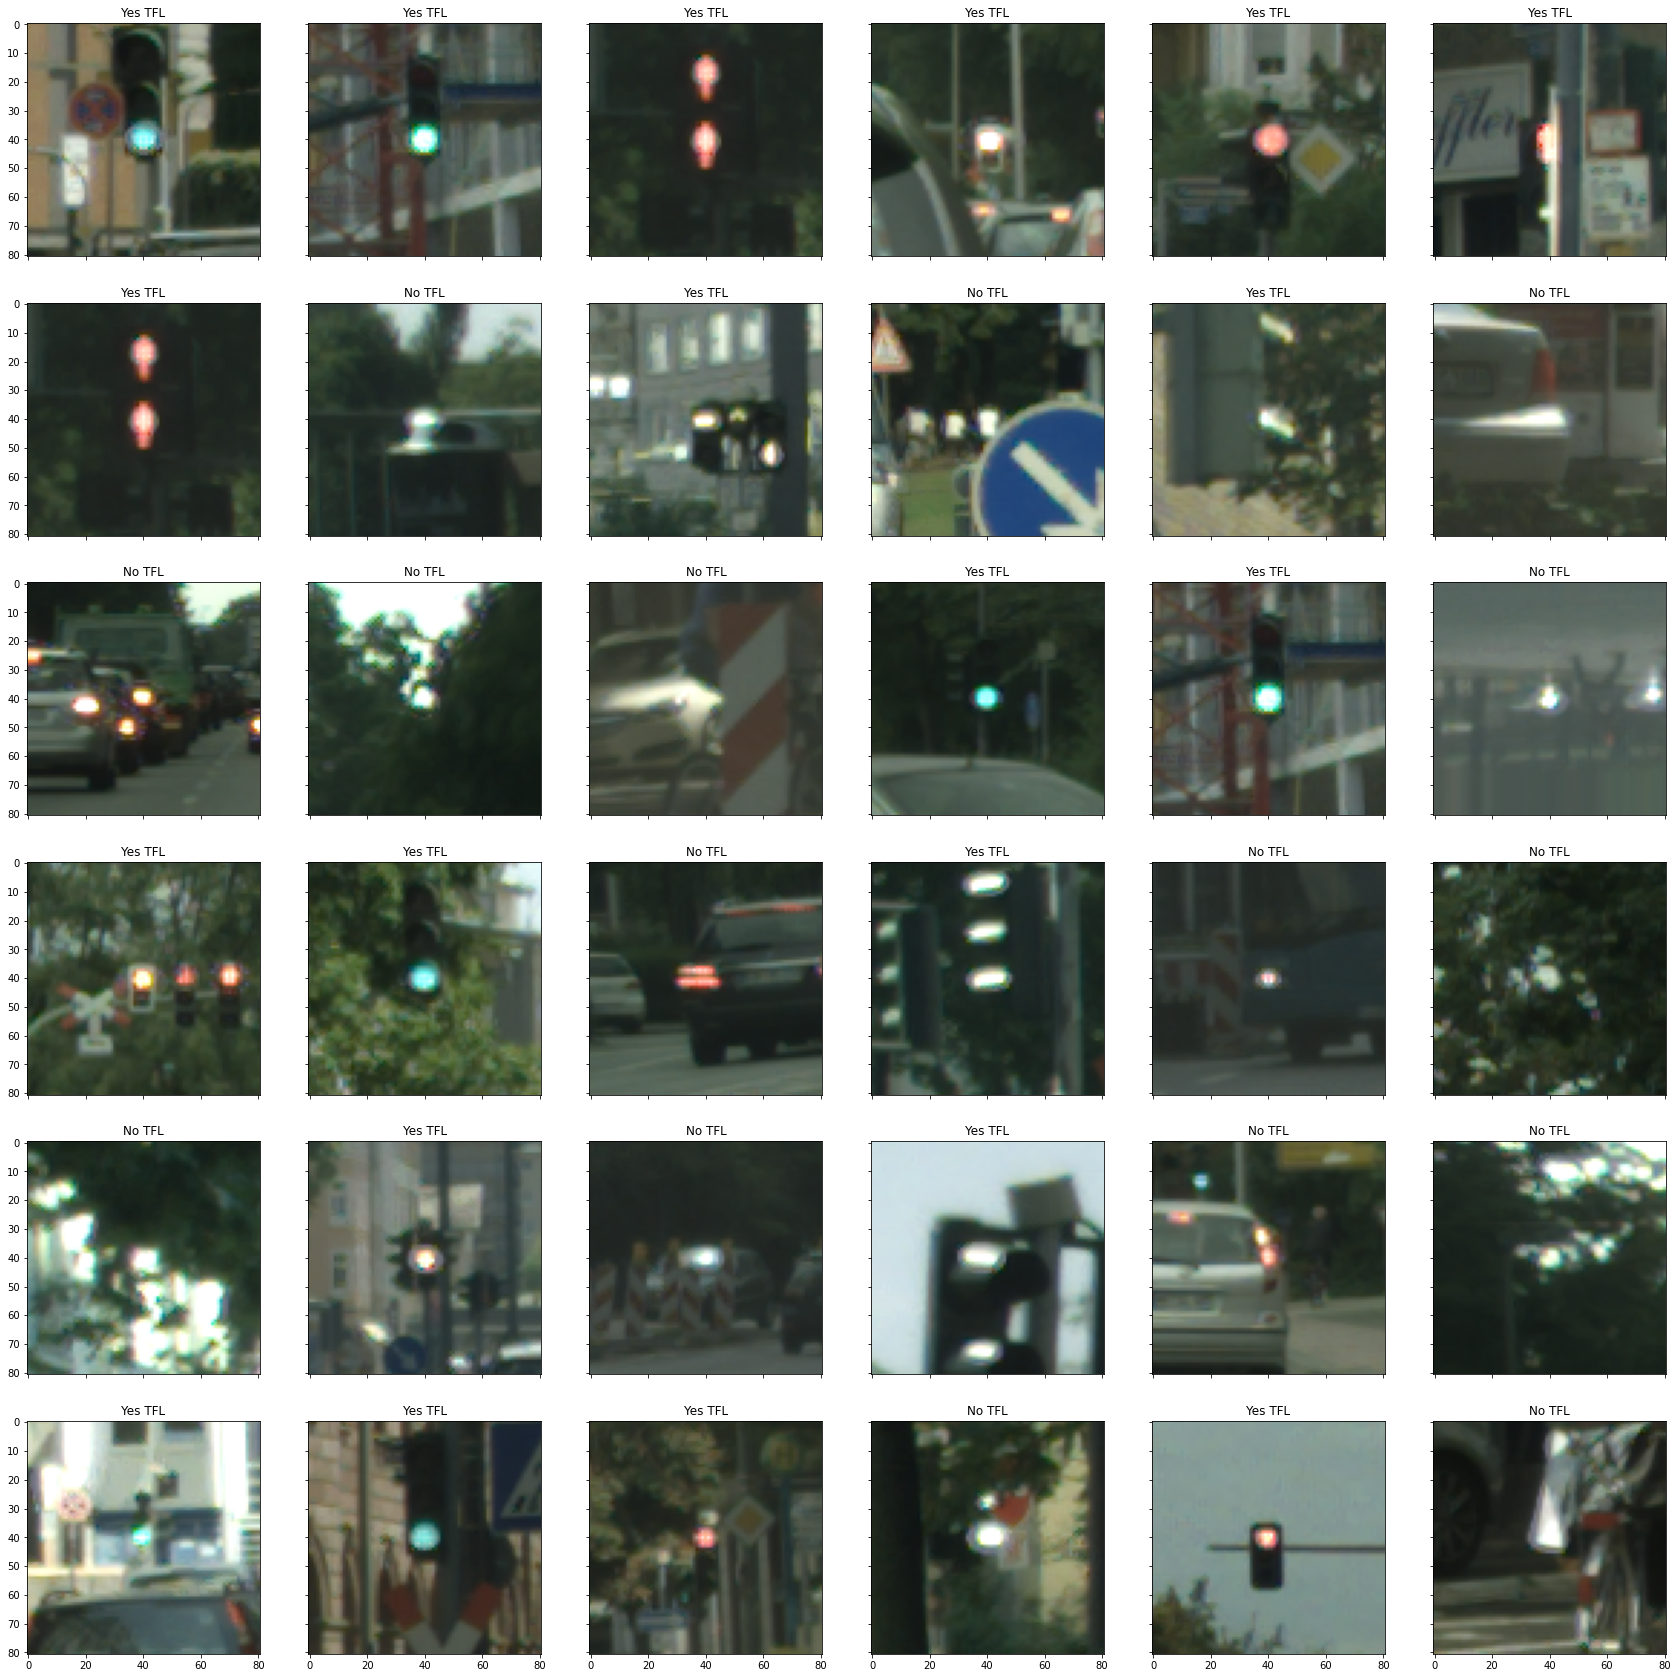

In [2]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
#     print(labels.shape[0], images.shape[0])
    
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
   


data_dir = '../data'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

## define the model used for training


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
        model.add(Activation('relu'))
    
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=True, kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3),padding="same")
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2) ,padding="same")
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape, padding="same")
#     model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    
    return model
m = tfl_model()
m.summary()

ModuleNotFoundError: No module named 'tensorflow'

In [13]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

## train

In [21]:
data_dir = '../tovi_data'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
#prepare our model
m = tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 7, batch_size=200)

Train on 3538 samples, validate on 416 samples
Epoch 1/7
3538/3538 [==============================] - 245s 69ms/sample - loss: 0.5631 - acc: 0.7174 - val_loss: 0.9179 - val_acc: 0.5577
Epoch 2/7
3538/3538 [==============================] - 192s 54ms/sample - loss: 0.2759 - acc: 0.8886 - val_loss: 1.3442 - val_acc: 0.5385
Epoch 3/7
3538/3538 [==============================] - 182s 52ms/sample - loss: 0.1463 - acc: 0.9497 - val_loss: 1.4483 - val_acc: 0.5120
Epoch 4/7
3538/3538 [==============================] - 212s 60ms/sample - loss: 0.0721 - acc: 0.9825 - val_loss: 0.7693 - val_acc: 0.6106
Epoch 5/7
3538/3538 [==============================] - 213s 60ms/sample - loss: 0.0562 - acc: 0.9845 - val_loss: 1.3466 - val_acc: 0.5120
Epoch 6/7
3538/3538 [==============================] - 199s 56ms/sample - loss: 0.0342 - acc: 0.9915 - val_loss: 0.9216 - val_acc: 0.5673
Epoch 7/7
 400/3538 [==>...........................] - ETA: 3:02 - loss: 0.0288 - acc: 0.9925

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\rent\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-c264db1c7db4>", line 12, in <module>
    history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 7, batch_size=200)
  File "C:\Users\RENT\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training.py", line 727, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\RENT\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 675, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\RENT\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 394, in model_iteration
    batch_outs = f(ins_batch)
  File "C:\Users\RENT\AppData\Roaming\Python\Py

TypeError: object of type 'NoneType' has no len()

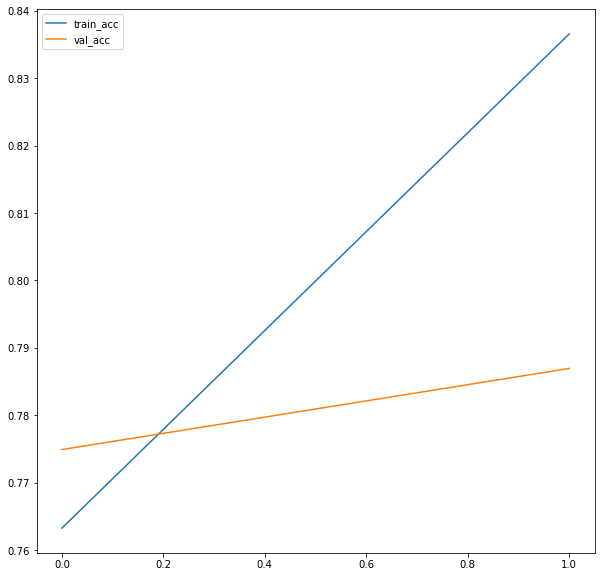

In [14]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_acc'] = epochs['acc']
plt.figure(figsize=(10,10))
for k in ['train_acc','val_acc']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

## evaluate and predict
Now thet we have a model we can use to predict results on the validation dataset.
1. What can say about example that fail prediction? can we find patterns that are common for failure cases?

accuracy: 0.7869415807560137


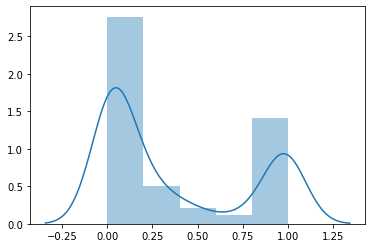

In [16]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

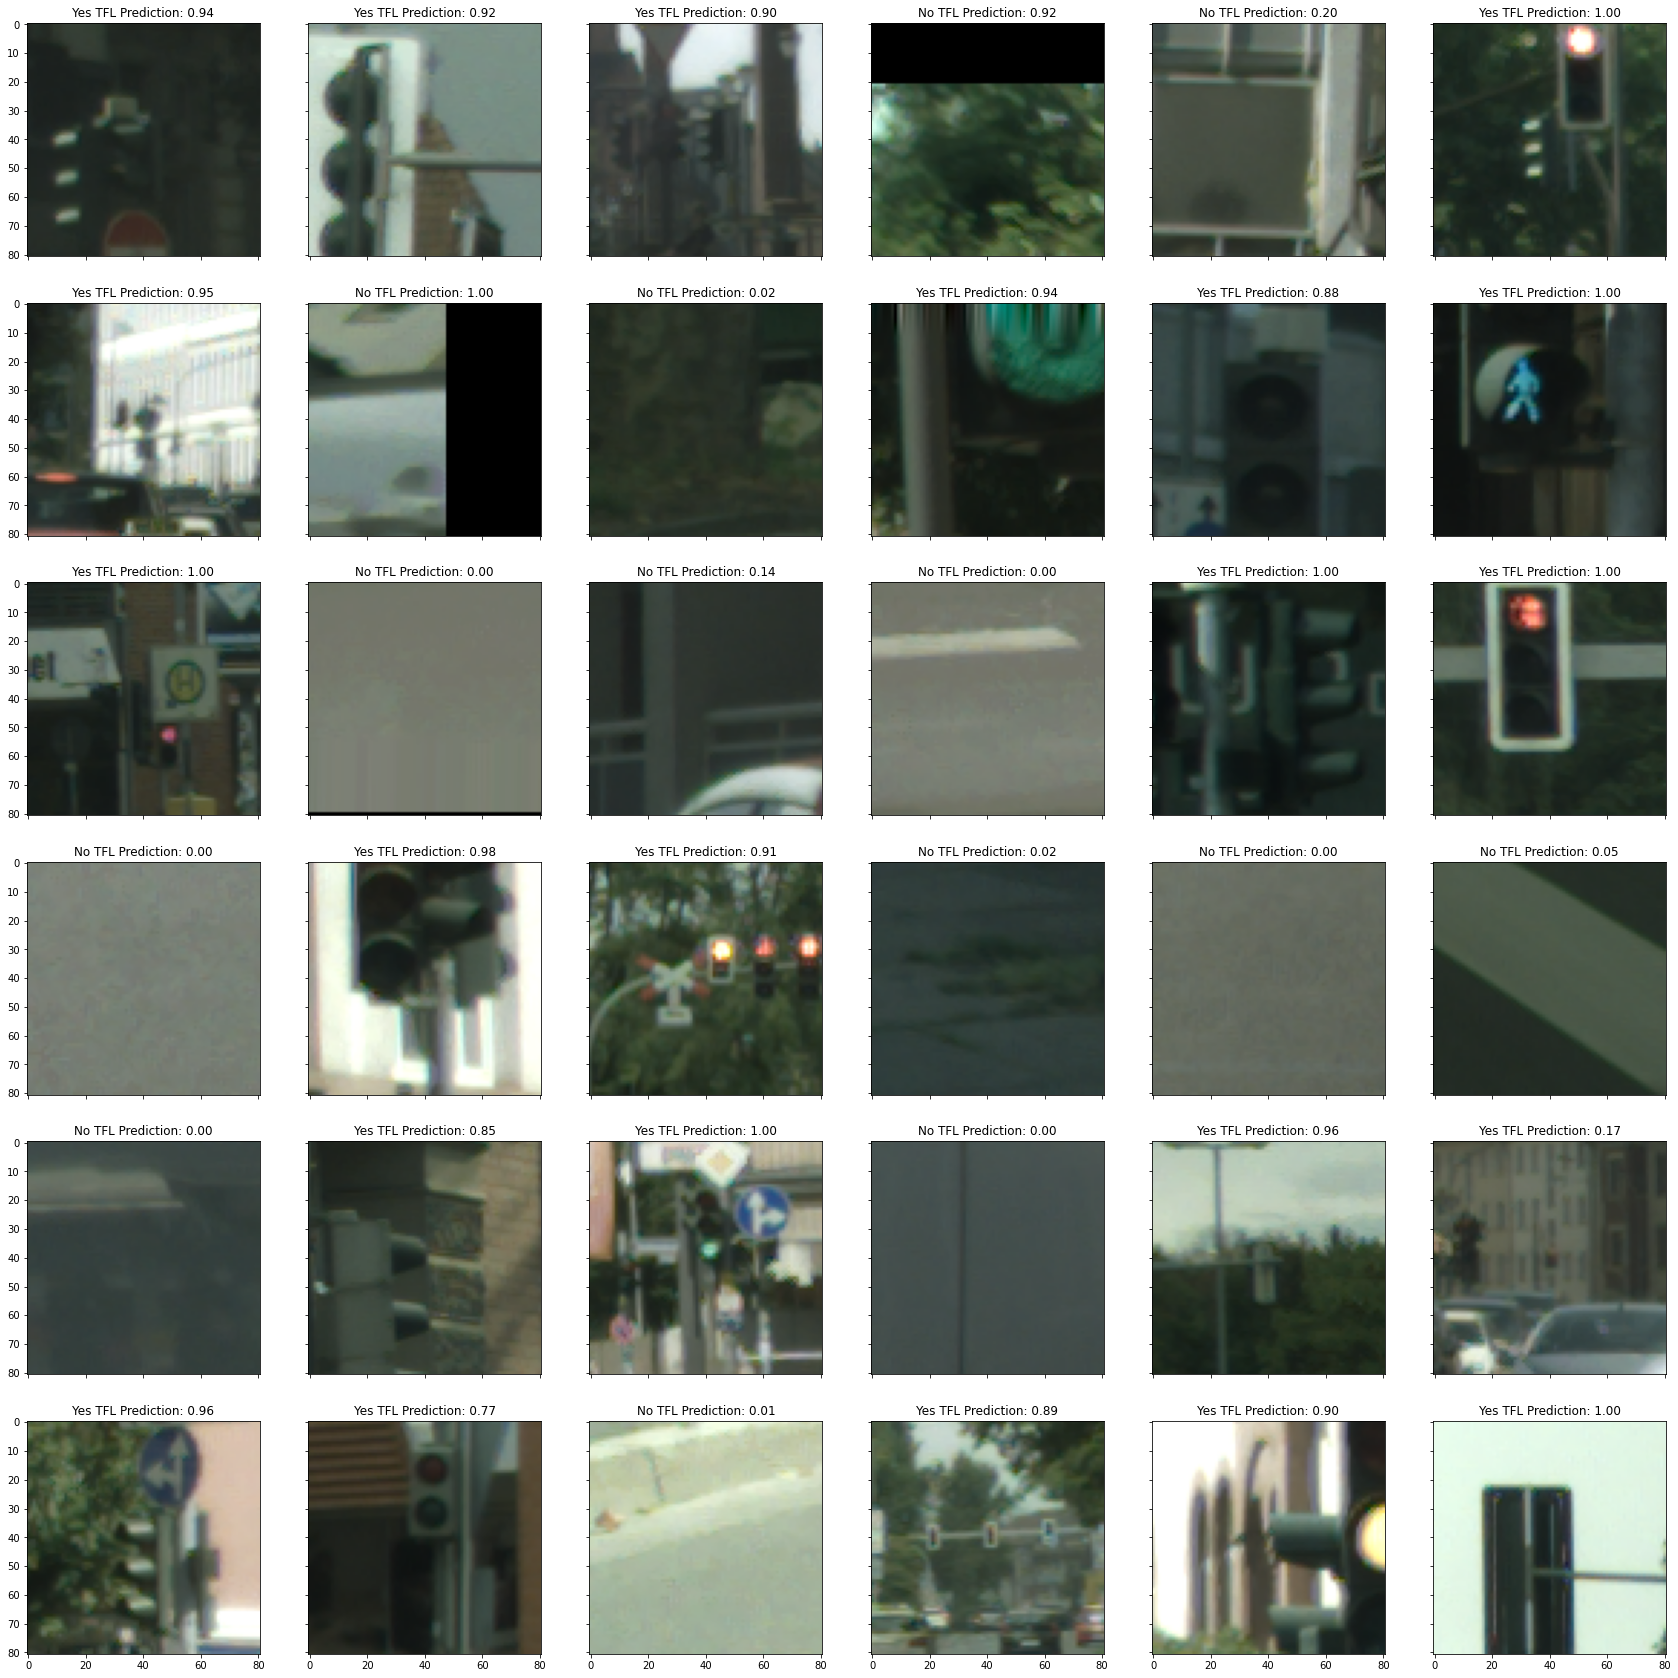

In [17]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

### Seek ways to improve resutls 
1. Try to play with diffferent models , increase / decrease the number of conv layers or number of  filters. you'll need to find a balanced model that is sufficiently large but minimzes overfit
    - try to enable tensorboard vizualization (see keras/ tensorboard doc) to help you carry the analysis
2. Data augmentation: feed your network with more examples by using data augmentation techniques: such as horizontal image flip, noise, etc

### Saving the model
After we trained our model and made predictions with it, we will now want to save the **architecture** together with its learned **weights** in order for us to be able to use it in the TFL manager.
The architecture will be saved as a json, the weights in the h5 format: 

In [18]:
m.save("model.h5")

### Loading the model

In [21]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h5")

accuracy: 0.7869415807560137


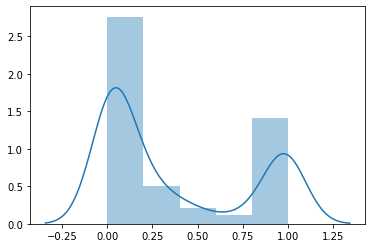

In [20]:
# code copied from the training evaluation: 
l_predictions = loaded_model.predict(val['images'])
sbn.distplot(l_predictions[:,0]);

l_predicted_label = np.argmax(l_predictions, axis=-1)
print ('accuracy:', np.mean(l_predicted_label==val['labels']))